In [1]:
from extract_dataframe import extract_data
import ssm
from ssm.util import find_permutation
from ssm.plots import gradient_cmap, white_to_color_cmap
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import csv , os , pickle , cv2 , tqdm , time
from ARHMM import find_best_K

(280251, 11)
Max speed of mouse:  4.089046591895863
147.25006924316568


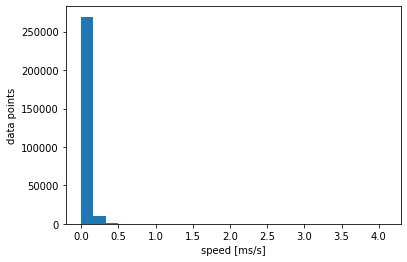

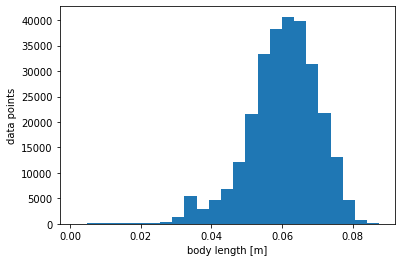

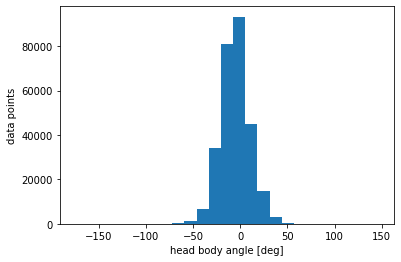

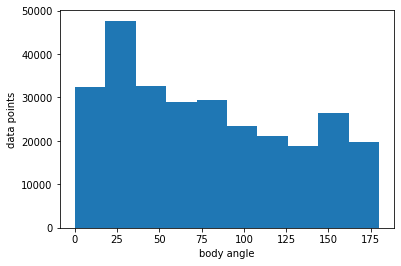

In [2]:
color_names = [
    "windows blue",
    "red",
    "amber",
    "faded green",
    "dusty purple",
    "orange"
    ]
colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)

data_frame = pd.read_csv("pose_data_2d.csv")
data_frame2 = pd.read_csv("new_data/20201013_behaviour2020_v_1105_10mw_10on_40hz_40pulses_1_pose_data.csv")
data_frame3 = pd.read_csv("new_data/20201013_behaviour2020_v_1107_10mw_5on_100hz_1_pose_data.csv")
data_frame4 = pd.read_csv("new_data/20201013_behaviour2020_v_1109_10mw_10on_40hz_40pulses_1_pose_data.csv")
data_frame5 = pd.read_csv("new_data/20201013_behaviour2020_v_3654_10mw_10on_40hz_40pulses_1_pose_data.csv")

data = data_frame.to_numpy()
#data= np.append(data,data_frame2.to_numpy(),axis=0)
#data= np.append(data,data_frame3.to_numpy(),axis=0)
#data= np.append(data,data_frame4.to_numpy(),axis=0)

#data = data_frame3.to_numpy() #data_frame3 innehåller data där musens kropp är 0 m
#data = data_frame2.to_numpy() #data_frame2 innehåller data där musens kropp är 0.01 m
#data = data_frame5.to_numpy()
print(data.shape)
box_size = 0.6 # size of box in m
box_pixel = 400 # number of pixels in box
d = 2 #number of frames between speed
T = 2e-3 # frame rate in seconds
speed = np.zeros(data.shape[0]-d)
for row_num in range(d,data.shape[0]):
    row = data[row_num,:]
    tail_x = data[row_num,5]
    tail_y = data[row_num,6]
    tail_x_prev = data[row_num-d,5]
    tail_y_prev = data[row_num-d,6]
    dT = d*T
    dxdt = (tail_x-tail_x_prev)/dT
    dydt = (tail_y-tail_y_prev)/dT
    speed[row_num-d] = box_size/box_pixel*np.sqrt(dxdt**2+dydt**2) #box 0.2 m and 400 px

print("Max speed of mouse: ",max(speed))
plt.figure(1)
plt.hist(speed, density=False, bins=25)
plt.ylabel('data points')
plt.xlabel('speed [ms/s]');

#body_len = np.linalg.norm(data[:,21:22],axis=1)
body_len = box_size/box_pixel*data[:,1]
plt.figure(2)
plt.hist(body_len, density=False,bins=25)
plt.ylabel('data points')
plt.xlabel('body length [m]');

#plot head body angle
head_body_angle = np.rad2deg(data[:,-1])
print(max(head_body_angle))
plt.figure(3)
plt.hist(head_body_angle, density=False,bins=25)
plt.ylabel('data points')
plt.xlabel('head body angle [deg]');

#plot body angle
body_angle = np.rad2deg(data[:,-2])
plt.figure(4)
plt.hist(body_angle, density=False)
plt.ylabel('data points')
plt.xlabel('body angle');

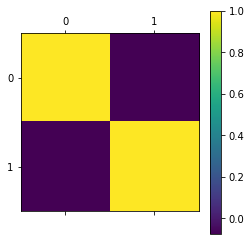

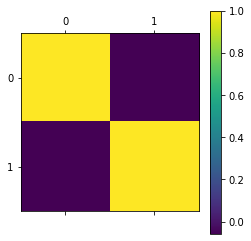

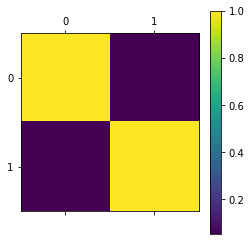

[[ 1.         -0.07540889]
 [-0.07540889  1.        ]]
[[ 1.         -0.05818682]
 [-0.05818682  1.        ]]
[[1.         0.05339093]
 [0.05339093 1.        ]]
(280249, 1)
147.25006924316568
0.08749694422238581


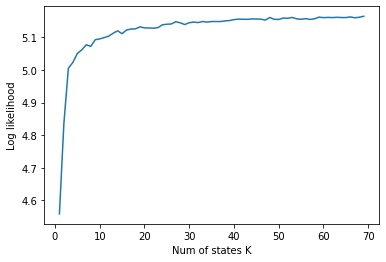

In [3]:
plt.matshow(np.corrcoef(speed,body_len[d:]));
plt.colorbar()
plt.show()

plt.matshow(np.corrcoef(speed,head_body_angle[d:]));
plt.colorbar()
plt.show()

plt.matshow(np.corrcoef(head_body_angle,body_len));
plt.colorbar()
plt.show()

print(np.corrcoef(speed,body_len[d:]))
print(np.corrcoef(speed,head_body_angle[d:]))
print(np.corrcoef(head_body_angle,body_len))

#data_to_use = np.array([speed,body_len[10:],head_body_angle[10:]]).T
data_to_use = speed.reshape((len(speed),1))
print(data_to_use.shape)
print(max(head_body_angle))
print(max(body_len))
lls = [4.55806317, 4.83601972, 5.00532188, 5.02291323, 5.0505462,  5.06165901,
 5.07734214, 5.07245544, 5.0927616,  5.09538789, 5.09923166, 5.10373015,
 5.11265816, 5.12010109, 5.11137256, 5.12269992, 5.12559868, 5.12627435,
 5.13232738, 5.12913428, 5.12894074, 5.12812359, 5.12988736, 5.13859679]

lls2 = [5.14030454, 5.14124792, 5.1479787,5.14474416, 5.13936708, 5.14508318,
 5.14697727,5.14551496, 5.14864859, 5.14692582, 5.14871145, 5.14867441,
 5.14870462, 5.15053502, 5.15166439, 5.15457889, 5.15586579, 5.15569459,
 5.15542992, 5.15665677, 5.15630861, 5.15597614, 5.15310356, 5.16114811,
 5.15536304]

lls3 = [5.15511107,5.159179,5.15866353,5.16116697,5.15707948,5.15549771,
 5.15753313,5.15513648,5.1571296,5.16214768,5.16057684,5.16136815,
 5.16077101,5.1616439,5.16095479,5.16084607,5.16277972,5.16024248,
 5.16184895,5.16489863]
plt.figure(1)
plt.plot(np.arange(1,70),np.append(np.append(lls,lls2),lls3))
plt.ylabel('Log likelihood')
plt.xlabel('Num of states K');
lls_40 = [5.18499082,5.178812,5.18377445,5.18123262,5.18487971,5.18820959,
    5.18869511,5.18209739,5.18510443,5.18992093]

In [4]:
start_K = 5
stop_K = 6

train_data, test_data, = train_test_split(data_to_use, test_size=0.3)
test_data, val_data = train_test_split(test_data, test_size=0.5)

best_train_lls, best_val_lls, best_test_ll, hmm, best_K =find_best_K(train_data, test_data, val_data,start_K,stop_K,2)
print("best train ll",best_train_lls)
print("best val ll",best_val_lls)
print("best test ll",best_test_ll)
print("best_K",best_K)

  0%|          | 0/1 [00:00<?, ?it/s]

{'lags': 1}


100%|██████████| 1/1 [00:29<00:00, 29.79s/it]

best train ll [1.63125358 1.65969175 1.67712564 1.69235981 1.70734913 1.72308516
 1.74004575 1.7578214  1.77509321 1.79032986 1.80279266 1.81265299
 1.820416   1.82656585 1.83150565 1.83557365 1.83903856 1.84209272
 1.84486274]
best val ll [1.62841582 1.65619442 1.67345924 1.68848424 1.70313255 1.71826978
 1.73445886 1.7514881  1.76821613 1.78316696 1.79552192 1.80536413
 1.81313506 1.81928188 1.82419318 1.82820711 1.83159841 1.83456468
 1.83723353]
best test ll 1.8421180298935125
best_K 5


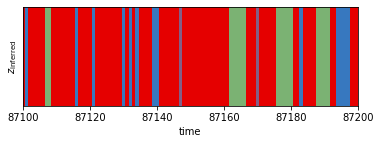

<Figure size 576x288 with 0 Axes>

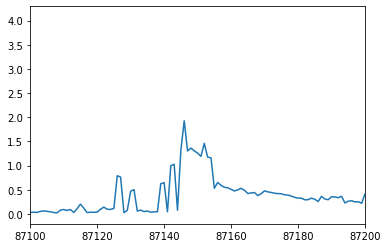

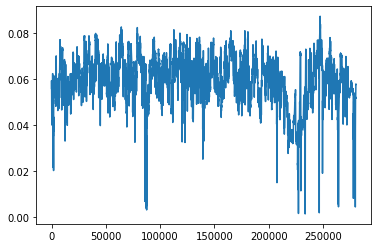

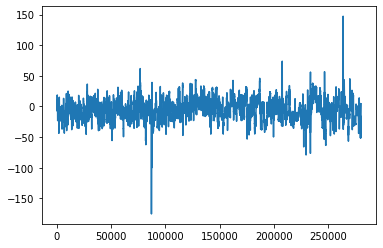

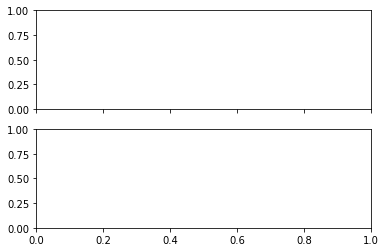

In [5]:
time_bins = train_data.shape[1]
hmm_z = hmm.most_likely_states(train_data)
plt.subplot(212)
plt.imshow(hmm_z[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(87100, 87200)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

learned_transition_mat = hmm.transitions.transition_matrix
fig = plt.figure(figsize=(8, 4))

#im = plt.imshow(learned_transition_mat, cmap='gray')
#plt.title("Learned Transition Matrix")

#cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
#fig.colorbar(im, cax=cbar_ax)
plt.show()

#plt.plot(np.arange(40,50),lls_40)
plt.figure(2)
plt.plot(np.arange(len(speed)),speed)
plt.xlim(87100, 87200)

plt.figure(3)
plt.plot(np.arange(len(body_len[10:])),body_len[10:])

plt.figure(4)
plt.plot(np.arange(len(head_body_angle[10:])),head_body_angle[10:])


fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
#ax1.xcorr(speed, body_len[10:], usevlines=True, maxlags=50, normed=True, lw=2)
#ax1.grid(True)

#ax2.acorr(speed, usevlines=True, normed=True, maxlags=1500, lw=2)
#ax2.grid(True)

#plt.show()

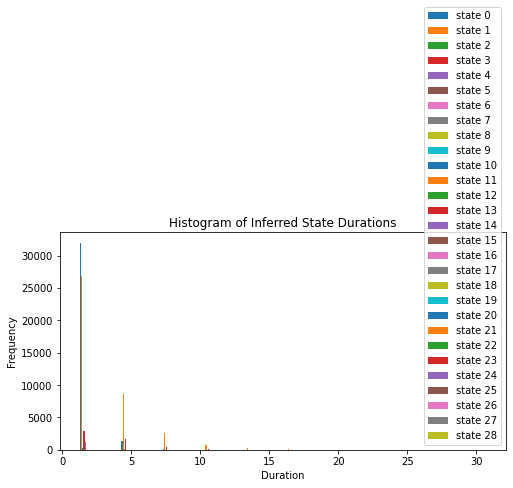

In [6]:
num_states = 29
#true_state_list, true_durations = ssm.util.rle(true_states)
inferred_state_list, inferred_durations = ssm.util.rle(hmm_z)

# Rearrange the lists of durations to be a nested list where
# the nth inner list is a list of durations for state n
#true_durs_stacked = []
inf_durs_stacked = []
for s in range(num_states):
    #true_durs_stacked.append(true_durations[true_state_list == s])
    inf_durs_stacked.append(inferred_durations[inferred_state_list == s])
"""
fig = plt.figure(figsize=(8, 4))
plt.hist(true_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of True State Durations')
"""    

fig = plt.figure(figsize=(8, 4))
plt.hist(inf_durs_stacked, label=['state ' + str(s) for s in range(num_states)])
plt.xlabel('Duration')
plt.ylabel('Frequency')
plt.legend()
plt.title('Histogram of Inferred State Durations')

plt.show()

In [7]:
#Merge states?

def merge_two_states(hmm, s1, s2, datas, observations="gaussian"):
    
    def collapse_and_sum_2d(arr, i, j, axis=0):
        assert axis <= 1
        out = arr.copy()
        if axis == 0:
            out[i,:] += out[j,:]
            return np.delete(out, j, axis=0)
        if axis == 1:
            out[:, i] += out[:, j]
            return np.delete(out, j, axis=1)
        
    K = hmm.K
    D = hmm.D
    assert K >= 2
    assert s1 < K
    assert s2 < K
    assert s1 != s2
    datas = datas if isinstance(datas, list) else [datas]
    inputs, masks, tags = [None], [None], [None]
    expectations = [hmm.expected_states(data, input, mask, tag)
                            for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    
    # Merge expectations for 2 states
    expectations_new = []
    for (Ez, Ezz, py) in expectations:
        T_curr = Ez.shape[0]
        
        # Put merged expectations in first column
        Ez_new = collapse_and_sum_2d(Ez, s1, s2, axis=1)
                
        # Now merge Ezz
        # Ezz will have shape 1, K, K
        # so we get rid of the first dimension then add it back.
        Ezz_new = collapse_and_sum_2d(Ezz[0], s1, s2, axis=0)
        Ezz_new = collapse_and_sum_2d(Ezz_new, s1, s2, axis=1)
        Ezz_new = Ezz_new[None, :, :]
        
        expectations_new.append((Ez_new, Ezz_new, py))
    
    # Perform M-Step to get params for new hmm
    new_hmm = ssm.HMM(K-1, D, observations=observations)
    new_hmm.init_state_distn.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.transitions.m_step(expectations_new, datas, inputs, masks, tags)
    new_hmm.observations.m_step(expectations_new, datas, inputs, masks, tags)
    
    # Evaluate log_likelihood
    expectations = [new_hmm.expected_states(data, input, mask, tag)
                    for data, input, mask, tag in zip(datas, inputs, masks, tags)]
    new_ll = new_hmm.log_prior() + sum([ll for (_, _, ll) in expectations])
    return new_ll, new_hmm

def plot_hmm(hmm, data):
    # Get the most likely state sequence
    states = hmm.most_likely_states(data)

    # Plot the observation distributions in the new model
    lim = .85 * abs(data).max()
    XX, YY = np.meshgrid(np.linspace(-lim, lim, 100), np.linspace(-lim, lim, 100))
    grid = np.column_stack((XX.ravel(), YY.ravel()))
    input = np.zeros((grid.shape[0], 0))
    mask = np.ones_like(grid, dtype=bool)
    tag = None
    lls = hmm.observations.log_likelihoods(grid, input, mask, tag)

    plt.figure(figsize=(6, 6))
    for k in range(hmm.K):
        plt.contour(XX, YY, np.exp(lls[:,k]).reshape(XX.shape), cmap=white_to_color_cmap(colors[k]))
        plt.plot(data[states==k, 0], data[states==k, 1], 'o', mfc=colors[k], mec='none', ms=4)

    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.title("Observation Distributions in merged HMM")
    
def make_similarity_matrix(hmm, data):
    num_states = hmm.K
    init_ll = hmm.log_probability(data)
    similarity = np.nan * np.ones((num_states, num_states))
    merged_hmms = np.empty((num_states, num_states), dtype=object)
    for s1 in range(num_states-1):
        for s2 in range(s1+1, num_states):
            merged_ll, merged_hmm = merge_two_states(hmm, s1, s2, data)
            similarity[s1, s2] = merged_ll - init_ll
            merged_hmms[s1, s2] = merged_hmm
            
    return similarity, merged_hmms

    num_states = hmm.K
    linkage = [None]
    likelihood_drops = [0]
    hmms = [hmm]
    
    if plot:
        plot_hmm(hmm, data)
    
    for i in range(num_states - 1):
        similarity, merged_hmms = make_similarity_matrix(hmms[-1], data)
        
        # Find the most similar states
        s1, s2 = np.where(similarity == np.nanmax(similarity))
        s1, s2 = s1[0], s2[0]
        linkage.append((s1, s2))
        likelihood_drops.append(similarity[s1, s2])
        hmms.append(merged_hmms[s1, s2])
        print("merging ", color_names[s1], "and", color_names[s2])
        
        if plot:
            plt.figure()
            im = plt.imshow(similarity)
            plt.ylabel("state 1")
            plt.xlabel("state 2")
            plt.title("similarity")
            plt.colorbar()
            
            plt.figure()
            plot_hmm(hmms[-1], data)
    
    return linkage, likelihood_drops, hmms

In [8]:
#linkage, likelihood_drops, hmms = hierarchical_cluster(hmm, train_data)
